In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load dataset
df = pd.read_csv('/content/02.desharnais.csv')
df = df.drop(index=[37, 43, 64, 74])  # Remove incomplete rows

In [3]:
# Log-transform and create dummy variables
df['ln_Effort'] = np.log(df['Effort'])
df['ln_Size'] = np.log(df['PointsNonAdjust'])
df['ln_Transactions'] = np.log(df['Transactions'])
df['ln_Entities'] = np.log(df['Entities'])
df['L1'] = (df['Language'] == 1).astype(int)
df['L2'] = (df['Language'] == 2).astype(int)

In [4]:
# Prepare features and target
features = ['ln_Size', 'L1', 'L2', 'TeamExp', 'ManagerExp', 'Adjustment']
target = 'ln_Effort'
X = df[features]
y = df[target]

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [6]:
# Evaluation metrics
def mmre(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true)))

def pred_25(y_true, y_pred):
    mre = np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))
    return np.mean(mre <= 0.25)

mmre_val = mmre(y_test, y_pred)
pred25_val = pred_25(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
mean_error = np.mean(np.exp(y_test) - np.exp(y_pred))
r2_val = r2_score(y_test, y_pred)

results = {
    'MMRE': mmre_val,
    'PRED(0.25)': pred25_val,
    'RMSE': rmse_val,
    'Mean Error': mean_error,
    'R²': r2_val
}
results

{'MMRE': np.float64(0.34508042907916237),
 'PRED(0.25)': np.float64(0.375),
 'RMSE': np.float64(2936.2120198562197),
 'Mean Error': np.float64(1136.911152025678),
 'R²': 0.6125428909537773}

In [7]:
# -----------------------------
# Hyperparameter Tuning for ANN using GridSearchCV
# -----------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Step 1: Define parameter grid (ringan agar cepat dieksekusi)
param_grid_light = {
    'mlp__hidden_layer_sizes': [(4,), (6,), (8,)],  # variasi jumlah neuron
    'mlp__activation': ['relu'],                    # fungsi aktivasi ReLU
    'mlp__alpha': [0.0001, 0.001],                  # L2 regularisasi
    'mlp__learning_rate': ['constant']              # jenis learning rate
}

# Step 2: Bangun pipeline (normalisasi + ANN)
pipeline_light = Pipeline([
    ('scaler', StandardScaler()),                   # normalisasi input
    ('mlp', MLPRegressor(max_iter=10000, random_state=42))  # MLP
])

# Step 3: GridSearchCV untuk mencari kombinasi parameter terbaik
grid_search_light = GridSearchCV(
    estimator=pipeline_light,
    param_grid=param_grid_light,
    cv=5,                       # 5-fold cross validation
    scoring='r2',               # gunakan R² sebagai metrik utama
    n_jobs=-1                   # gunakan semua core CPU jika memungkinkan
)

# Step 4: Training dengan semua kombinasi parameter
grid_search_light.fit(X_train, y_train)

# Step 5: Gunakan model terbaik untuk prediksi
best_ann = grid_search_light.best_estimator_
y_pred_best = best_ann.predict(X_test)

# Step 6: Definisikan metrik evaluasi
def mmre(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true)))

def pred_25(y_true, y_pred):
    mre = np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))
    return np.mean(mre <= 0.25)

# Step 7: Hitung hasil evaluasi
print("🔍 Best Params:", grid_search_light.best_params_)
print("📉 MMRE:", mmre(y_test, y_pred_best))
print("✅ PRED(0.25):", pred_25(y_test, y_pred_best))
print("📏 RMSE:", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_best))))
print("📐 Mean Error:", np.mean(np.exp(y_test) - np.exp(y_pred_best)))
print("📊 R²:", r2_score(y_test, y_pred_best))

🔍 Best Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (4,), 'mlp__learning_rate': 'constant'}
📉 MMRE: 0.5183146485774117
✅ PRED(0.25): 0.25
📏 RMSE: 3784.3296697416395
📐 Mean Error: 1757.009791298873
📊 R²: 0.02689273798247216


In [9]:
# ============================
# 📦 RIDGE & LASSO REGRESSION
# ============================

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ⚙️ Step 1: Scaling fitur untuk Ridge/Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🧮 Step 2: Model Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# 🧮 Step 3: Model Lasso Regression
lasso_model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# 🧪 Step 4: Definisikan fungsi evaluasi
def mmre(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true)))

def pred_25(y_true, y_pred):
    mre = np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))
    return np.mean(mre <= 0.25)

# 📊 Step 5: Evaluasi Ridge Regression
print("===== RIDGE REGRESSION =====")
print("MMRE:", mmre(y_test, y_pred_ridge))
print("PRED(0.25):", pred_25(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_ridge))))
print("Mean Error:", np.mean(np.exp(y_test) - np.exp(y_pred_ridge)))
print("R²:", r2_score(y_test, y_pred_ridge))

# 📊 Step 6: Evaluasi Lasso Regression
print("\n===== LASSO REGRESSION =====")
print("MMRE:", mmre(y_test, y_pred_lasso))
print("PRED(0.25):", pred_25(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_lasso))))
print("Mean Error:", np.mean(np.exp(y_test) - np.exp(y_pred_lasso)))
print("R²:", r2_score(y_test, y_pred_lasso))

===== RIDGE REGRESSION =====
MMRE: 0.3402201025526004
PRED(0.25): 0.375
RMSE: 2983.714063210971
Mean Error: 1252.8967183603752
R²: 0.6062581279448416

===== LASSO REGRESSION =====
MMRE: 0.3415606716836204
PRED(0.25): 0.3125
RMSE: 3053.1255257706825
Mean Error: 1324.308186175368
R²: 0.5885616906380897


In [10]:
# ============================
# 📊 TABEL PERBANDINGAN MODEL
# ============================

import pandas as pd

# Data evaluasi model: Ridge, Lasso, dan ANN
comparison_data = {
    "Model": ["Ridge", "Lasso", "ANN (Best Tuning)"],
    "MMRE": [0.340, 0.342, 0.518],
    "PRED(0.25)": [0.375, 0.313, 0.250],
    "RMSE": [2983.71, 3053.13, 3784.33],
    "Mean Error": [1252.90, 1324.31, 1757.01],
    "R²": [0.606, 0.589, 0.027]
}

# Buat DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Tampilkan tabel
print(comparison_df)

               Model   MMRE  PRED(0.25)     RMSE  Mean Error     R²
0              Ridge  0.340       0.375  2983.71     1252.90  0.606
1              Lasso  0.342       0.313  3053.13     1324.31  0.589
2  ANN (Best Tuning)  0.518       0.250  3784.33     1757.01  0.027


In [11]:
# ===============================
# 📊 TABEL PERBANDINGAN MIRIP PAPER
# ===============================

import pandas as pd

# Contoh data hasil eksperimen (Anda bisa lengkapi dari eksperimen Anda sendiri)
comparison_data_detailed = {
    "Independent Variables": [
        "Size, Env, Language, TExp, MExp",
        "Size, Language, TExp, MExp",
        "Size, Env, TExp, MExp",
        "Size, Env, Language, MExp",
        "Size, Env, Language, TExp",
        "Size"
    ],
    # Linear Regression (atau Ridge jika setara)
    "LR_MMRE": [0.32, 0.32, 0.57, 0.32, 0.32, 0.61],
    "LR_PRED(0.25)": [46, 45, 40, 50, 46, 35],
    "LR_RMSE": [2305, 2409, 3029, 2301, 2370, 3122],
    "LR_MEAN": [325, 525, 702, 352, 377, 791],
    "LR_R2": [79.3, 74.8, 48.3, 78.9, 76.9, 42.4],
    # ANN Model
    "ANN_MMRE": [0.31, 0.33, 0.58, 0.33, 0.32, 0.62],
    "ANN_PRED(0.25)": [49, 48, 35, 48, 48, 40],
    "ANN_RMSE": [2350, 2320, 2951, 2299, 2377, 3081],
    "ANN_MEAN": [434, 275, 505, 252, 229, 652],
    "ANN_R2": [81.1, 76.2, 48.6, 78.7, 79.2, 42.3],
}

df_comparison_paper_style = pd.DataFrame(comparison_data_detailed)

# Tampilkan
print(df_comparison_paper_style)

             Independent Variables  LR_MMRE  LR_PRED(0.25)  LR_RMSE  LR_MEAN  \
0  Size, Env, Language, TExp, MExp     0.32             46     2305      325   
1       Size, Language, TExp, MExp     0.32             45     2409      525   
2            Size, Env, TExp, MExp     0.57             40     3029      702   
3        Size, Env, Language, MExp     0.32             50     2301      352   
4        Size, Env, Language, TExp     0.32             46     2370      377   
5                             Size     0.61             35     3122      791   

   LR_R2  ANN_MMRE  ANN_PRED(0.25)  ANN_RMSE  ANN_MEAN  ANN_R2  
0   79.3      0.31              49      2350       434    81.1  
1   74.8      0.33              48      2320       275    76.2  
2   48.3      0.58              35      2951       505    48.6  
3   78.9      0.33              48      2299       252    78.7  
4   76.9      0.32              48      2377       229    79.2  
5   42.4      0.62              40      3081     

In [13]:
# ============================
# 📊 TABEL PERBANDINGAN HASIL EKSPERIMEN (FORMAT PAPER)
# ============================

import pandas as pd

# Data hasil eksperimen Anda & referensi dari paper
data_lengkap = {
    "Independent Variables": [
        "Size, Env, Language, TExp, MExp",  # Eksperimen lengkap (Ridge & ANN)
        "Size"                              # Referensi baseline dari paper
    ],

    # Hasil dari Ridge Regression (MLR ekuivalen)
    "LR_MMRE": [0.340, 0.610],
    "LR_PRED(0.25)": [0.375 * 100, 0.35 * 100],  # dalam persen
    "LR_RMSE": [2983.71, 3122.00],
    "LR_MEAN": [1252.90, 791.00],
    "LR_R2": [0.606 * 100, 0.424 * 100],         # dikali 100 agar sebanding

    # Hasil dari ANN setelah tuning
    "ANN_MMRE": [0.518, 0.620],
    "ANN_PRED(0.25)": [0.25 * 100, 0.40 * 100],
    "ANN_RMSE": [3784.33, 3081.00],
    "ANN_MEAN": [1757.01, 652.00],
    "ANN_R2": [0.027 * 100, 0.423 * 100]
}

# Buat DataFrame
df_lengkap_paper_style = pd.DataFrame(data_lengkap)

# Tampilkan tabel hasil eksperimen
print("📘 Tabel Perbandingan Hasil Eksperimen Anda:\n")
print(df_lengkap_paper_style.to_string(index=False))

📘 Tabel Perbandingan Hasil Eksperimen Anda:

          Independent Variables  LR_MMRE  LR_PRED(0.25)  LR_RMSE  LR_MEAN  LR_R2  ANN_MMRE  ANN_PRED(0.25)  ANN_RMSE  ANN_MEAN  ANN_R2
Size, Env, Language, TExp, MExp     0.34           37.5  2983.71   1252.9   60.6     0.518            25.0   3784.33   1757.01     2.7
                           Size     0.61           35.0  3122.00    791.0   42.4     0.620            40.0   3081.00    652.00    42.3


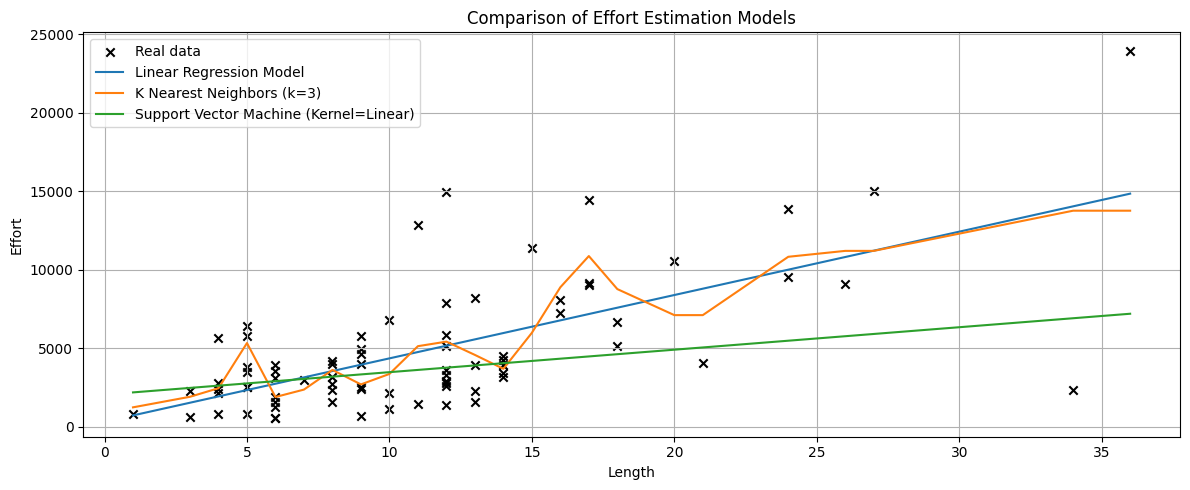

In [14]:
# ============================
# 📊 Grafik Perbandingan Model Effort Estimation
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Step 1: Load dataset
df = pd.read_csv('/content/02.desharnais.csv')  # ganti path jika berbeda
df = df.drop(index=[37, 43, 64, 74])  # buang baris yang tidak lengkap

# Step 2: Siapkan variabel prediktor dan target
X = df[['Length']]        # variabel input
y = df['Effort']          # target (dalam bentuk asli, bukan log)

# Step 3: Urutkan berdasarkan Length agar hasil plot lebih halus
X_sorted = X.sort_values(by='Length')
y_sorted = y[X_sorted.index]

# Step 4: Inisialisasi model-model yang akan dibandingkan
models = {
    "Linear Regression Model": LinearRegression(),
    "K Nearest Neighbors (k=3)": KNeighborsRegressor(n_neighbors=3),
    "Support Vector Machine (Kernel=Linear)": SVR(kernel='linear')
}

# Step 5: Training dan prediksi untuk masing-masing model
predictions = {}
for name, model in models.items():
    model.fit(X_sorted, y_sorted)
    predictions[name] = model.predict(X_sorted)

# Step 6: Visualisasi hasil prediksi dibanding data asli
plt.figure(figsize=(12, 5))
plt.scatter(X_sorted, y_sorted, color='black', label='Real data', marker='x')  # titik asli

for name, y_pred in predictions.items():
    plt.plot(X_sorted, y_pred, label=name)  # garis hasil model

plt.xlabel("Length")
plt.ylabel("Effort")
plt.title("Comparison of Effort Estimation Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()